In [1]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import sys
sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
neon = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")


In [3]:
### Get all IDs

flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/")


import re

file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
file_ids = [re.sub("F", "", x) for x in file_ids]

file_ids = set(file_ids)

In [4]:
len(file_ids)

573

In [5]:
manyfr = pd.read_csv("/projects/old_shared/fire_spread/WesternUS_REDO_all_west_2020_2023-08-01station_spread.csv")

/tmp/ipykernel_10538/2579067106.py:1: DtypeWarning: Columns (10,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  manyfr = pd.read_csv("/projects/old_shared/fire_spread/WesternUS_REDO_all_west_2020_2023-08-01station_spread.csv")


In [6]:
len(manyfr.fireID.unique())

301

In [7]:
manyfr["spread_aggrigate"] = (manyfr['spread_periodNight'] | manyfr['spread_periodDay'] | manyfr['spread_periodNight_igs'] | manyfr['spread_periodDay_igs'])


manyfr["spread_aggrigate_no_igs"] = (manyfr['spread_periodNight'] | manyfr['spread_periodDay'])

manyfr["spread_aggrigate_only_igs"] = (manyfr['spread_periodNight_igs'] | manyfr['spread_periodDay_igs'])

In [8]:
tmp = manyfr.groupby(by = ["fireID", "spread_periodNight"]).FWI.mean()

In [9]:
manyfr["spread_aggrigate"].unique()

array([ True, False])

In [10]:
#tmp= pd.DataFrame({'mean' : manyfr.groupby(  ["fireID", "spread_aggrigate"]).FWI.mean()}).reset_index()

tmp = manyfr.groupby(  ["fireID", 'spread_aggrigate'], as_index = False).FWI.mean()

no_spreading = manyfr.groupby(  ["fireID"], as_index = False ).duration.max()
farea = manyfr.groupby(  ["fireID"], as_index = False ).farea.max()

In [11]:
tmp = tmp.merge( no_spreading, how = "outer", on = "fireID")
tmp = tmp.merge(farea, how = "outer", on = "fireID")
tmp

fireID  spread_aggrigate        FWI  duration      farea
0        67             False   0.731295       5.0   8.569367
1        67              True   2.432343       5.0   8.569367
2       173             False        NaN       4.0   8.507914
3       173              True        NaN       4.0   8.507914
4       186             False   2.105460       8.5  18.860567
..      ...               ...        ...       ...        ...
597   20084              True   1.441841       8.0   5.696567
598   20216             False   4.298247       0.5   5.300283
599   20216              True        NaN       0.5   5.300283
600   20293             False  20.972178       1.0   5.395639
601   20293              True  38.873368       1.0   5.395639

[602 rows x 5 columns]

In [12]:
tmp['FWI_max']= manyfr.groupby(  ["fireID", 'spread_aggrigate'], as_index = False).FWI.max().FWI

tmp['FWI_min']= manyfr.groupby(  ["fireID", 'spread_aggrigate'], as_index = False).FWI.min().FWI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


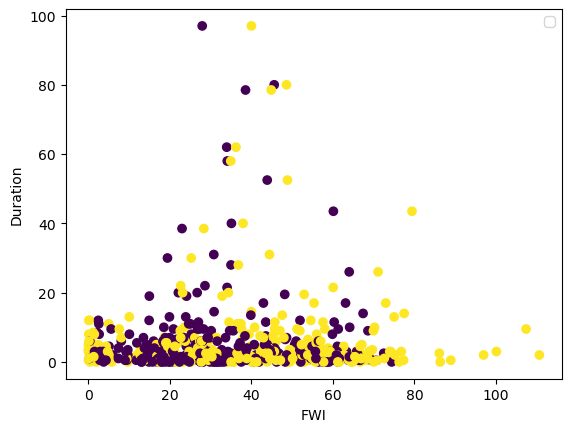

In [13]:
plt.scatter(tmp.FWI, tmp.duration, c = tmp.spread_aggrigate)
plt.xlabel("FWI")
plt.ylabel("Duration")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


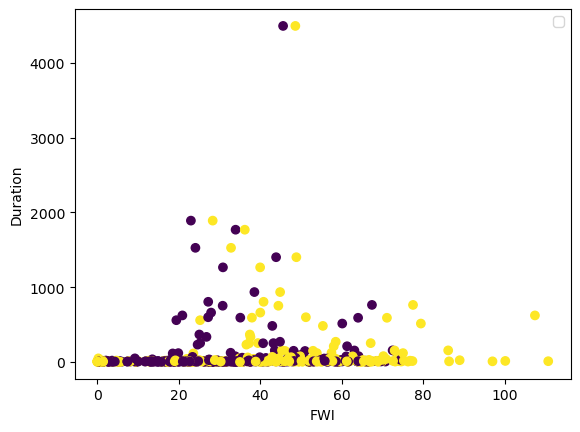

In [14]:
plt.scatter(tmp.FWI, tmp.farea, c = tmp.spread_aggrigate)
plt.xlabel("FWI")
plt.ylabel("Duration")
plt.legend()

In [15]:
print(tmp[tmp.spread_aggrigate == True].FWI_max.mean())
print(tmp[tmp.spread_aggrigate == True].FWI_max.std())

print(tmp[tmp.spread_aggrigate == False].FWI_max.mean())
print(tmp[tmp.spread_aggrigate == False].FWI_max.std())

82.28953435017303
51.48535565267428
112.01265899999999
51.398880951929186


In [16]:
print(tmp[tmp.spread_aggrigate == True].FWI_min.mean())
print(tmp[tmp.spread_aggrigate == True].FWI_min.std())

print(tmp[tmp.spread_aggrigate == False].FWI_min.mean())
print(tmp[tmp.spread_aggrigate == False].FWI_min.std())

18.592763199989356
13.969351812613013
5.156969422868446
8.508140846120646


In [17]:
#tmp['test_max_duration'] = no_spreading

#tmp

In [18]:
tmp.spread_aggrigate.unique()

array([False,  True])

In [19]:
var = "FWI"
ids_with_only_t_or_f = []
ids_with_na_var_values = []
difference_vals = []


for f in tmp.fireID.unique():
    small = tmp[tmp.fireID == f]
    if(len(small.spread_aggrigate.unique()) == 2):
        small = small[["fireID", "spread_aggrigate", var]].dropna()
        if(len(small) == 2):
            diff = float(small[small.spread_aggrigate == True][var]) - float(small[small.spread_aggrigate == False][var])
            difference_vals.append([f, diff])
        else:
            ids_with_na_var_values.append(f)
    else:
        ids_with_only_t_or_f_or_nan.append(f)
        
        

In [20]:
diff_fwi = pd.DataFrame(data = difference_vals, columns=["fireID", "diff_fwi"])

#plt.hist(diff_fwi.diff)
diff_fwi.diff_fwi.hist()
print("mean:" + str(diff_fwi.diff_fwi.mean()))

tmp = tmp.merge(diff_fwi, how = "outer", on = "fireID")

mean:6.339774874728328


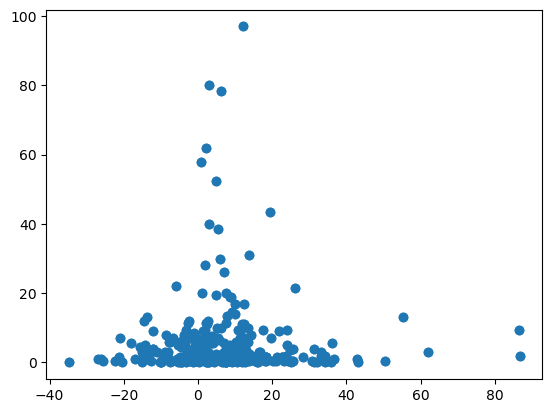

In [21]:
plt.scatter(tmp.diff_fwi, tmp.duration)

In [22]:
manyfr.columns

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'fline_diff', 'farea_diff', 'spread_line', 'spread_lineNight',
       'spread_lineDay', 'spread_day', 'st_ID', 'st_dist_to_fire', 'YYYY',
       'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format',
       'spread_periodNight', 'spread_periodNight_igs',
       'spread_periodNight_lag_-2', 'spread_periodNight_lag_-4',
       'spread_periodNight_lag_-12', 'spread_periodNight_lag_-24',
       'spread_periodNight_lag_-48', 'spread_periodDay',
       'spread_periodDay_igs', 'spread_periodDay_lag_-2',
       'spread_periodDay_lag_-4', 'spread_periodDay_lag_-12',
       'spread_periodDay_lag_-24', 'spread_periodDay_lag_-

In [23]:
## Check what's up with the 0 FWI numbers 


geoms = manyfr.groupby(  ["fireID"], as_index = False ).geometry.last()
tmp = tmp.merge(geoms, how = "outer", on = ["fireID"])
tmp = tmp[['fireID', 'spread_aggrigate', 'FWI', 'duration', 'farea', 'FWI_max',
       'FWI_min', 'diff_fwi', 'geometry']]

In [24]:
tmp = gpd.GeoDataFrame(data = tmp)

from shapely import wkt

tmp['geometry'] = tmp['geometry'].apply(wkt.loads)
tmp.set_crs("epsg:4326")

fireID  spread_aggrigate        FWI  duration      farea   FWI_max  \
0        67             False   0.731295       5.0   8.569367    6.9778   
1        67              True   2.432343       5.0   8.569367    5.5583   
2       173             False        NaN       4.0   8.507914       NaN   
3       173              True        NaN       4.0   8.507914       NaN   
4       186             False   2.105460       8.5  18.860567   19.2020   
..      ...               ...        ...       ...        ...       ...   
597   20084              True   1.441841       8.0   5.696567    5.3261   
598   20216             False   4.298247       0.5   5.300283   12.9300   
599   20216              True        NaN       0.5   5.300283       NaN   
600   20293             False  20.972178       1.0   5.395639   88.9120   
601   20293              True  38.873368       1.0   5.395639  102.2400   

          FWI_min   diff_fwi  \
0    1.212700e-08   1.701049   
1    6.800200e-01   1.701049   
2             NaN        NaN   
3             NaN        NaN   
4    6.053600e-07  -0.961102   
..            ...        ...   
597  2.443500e-01  -8.612892   
598  6.507200e-01        NaN   
599           NaN        NaN   
600  8.085200e-01  17.901190   
601  1.699700e+01  17.901190   

                                              geometry  
0    MULTIPOLYGON (((-122.43982 41.02830, -122.4396...  
1    MULTIPOLYGON (((-122.43982 41.02830, -122.4396...  
2    MULTIPOLYGON (((-104.90004 36.95651, -104.9000...  
3    MULTIPOLYGON (((-104.90004 36.95651, -104.9000...  
4    MULTIPOLYGON (((-119.98405 37.92562, -119.9840...  
..                                                 ...  
597  POLYGON ((-122.81796 38.70192, -122.81795 38.7...  
598  POLYGON ((-105.28429 37.34362, -105.28425 37.3...  
599  POLYGON ((-105.28429 37.34362, -105.28425 37.3...  
600  POLYGON ((-103.90049 32.39074, -103.90053 32.3...  
601  POLYGON ((-103.90049 32.39074, -103.90053 32.3...  

[602 rows x 9 columns]

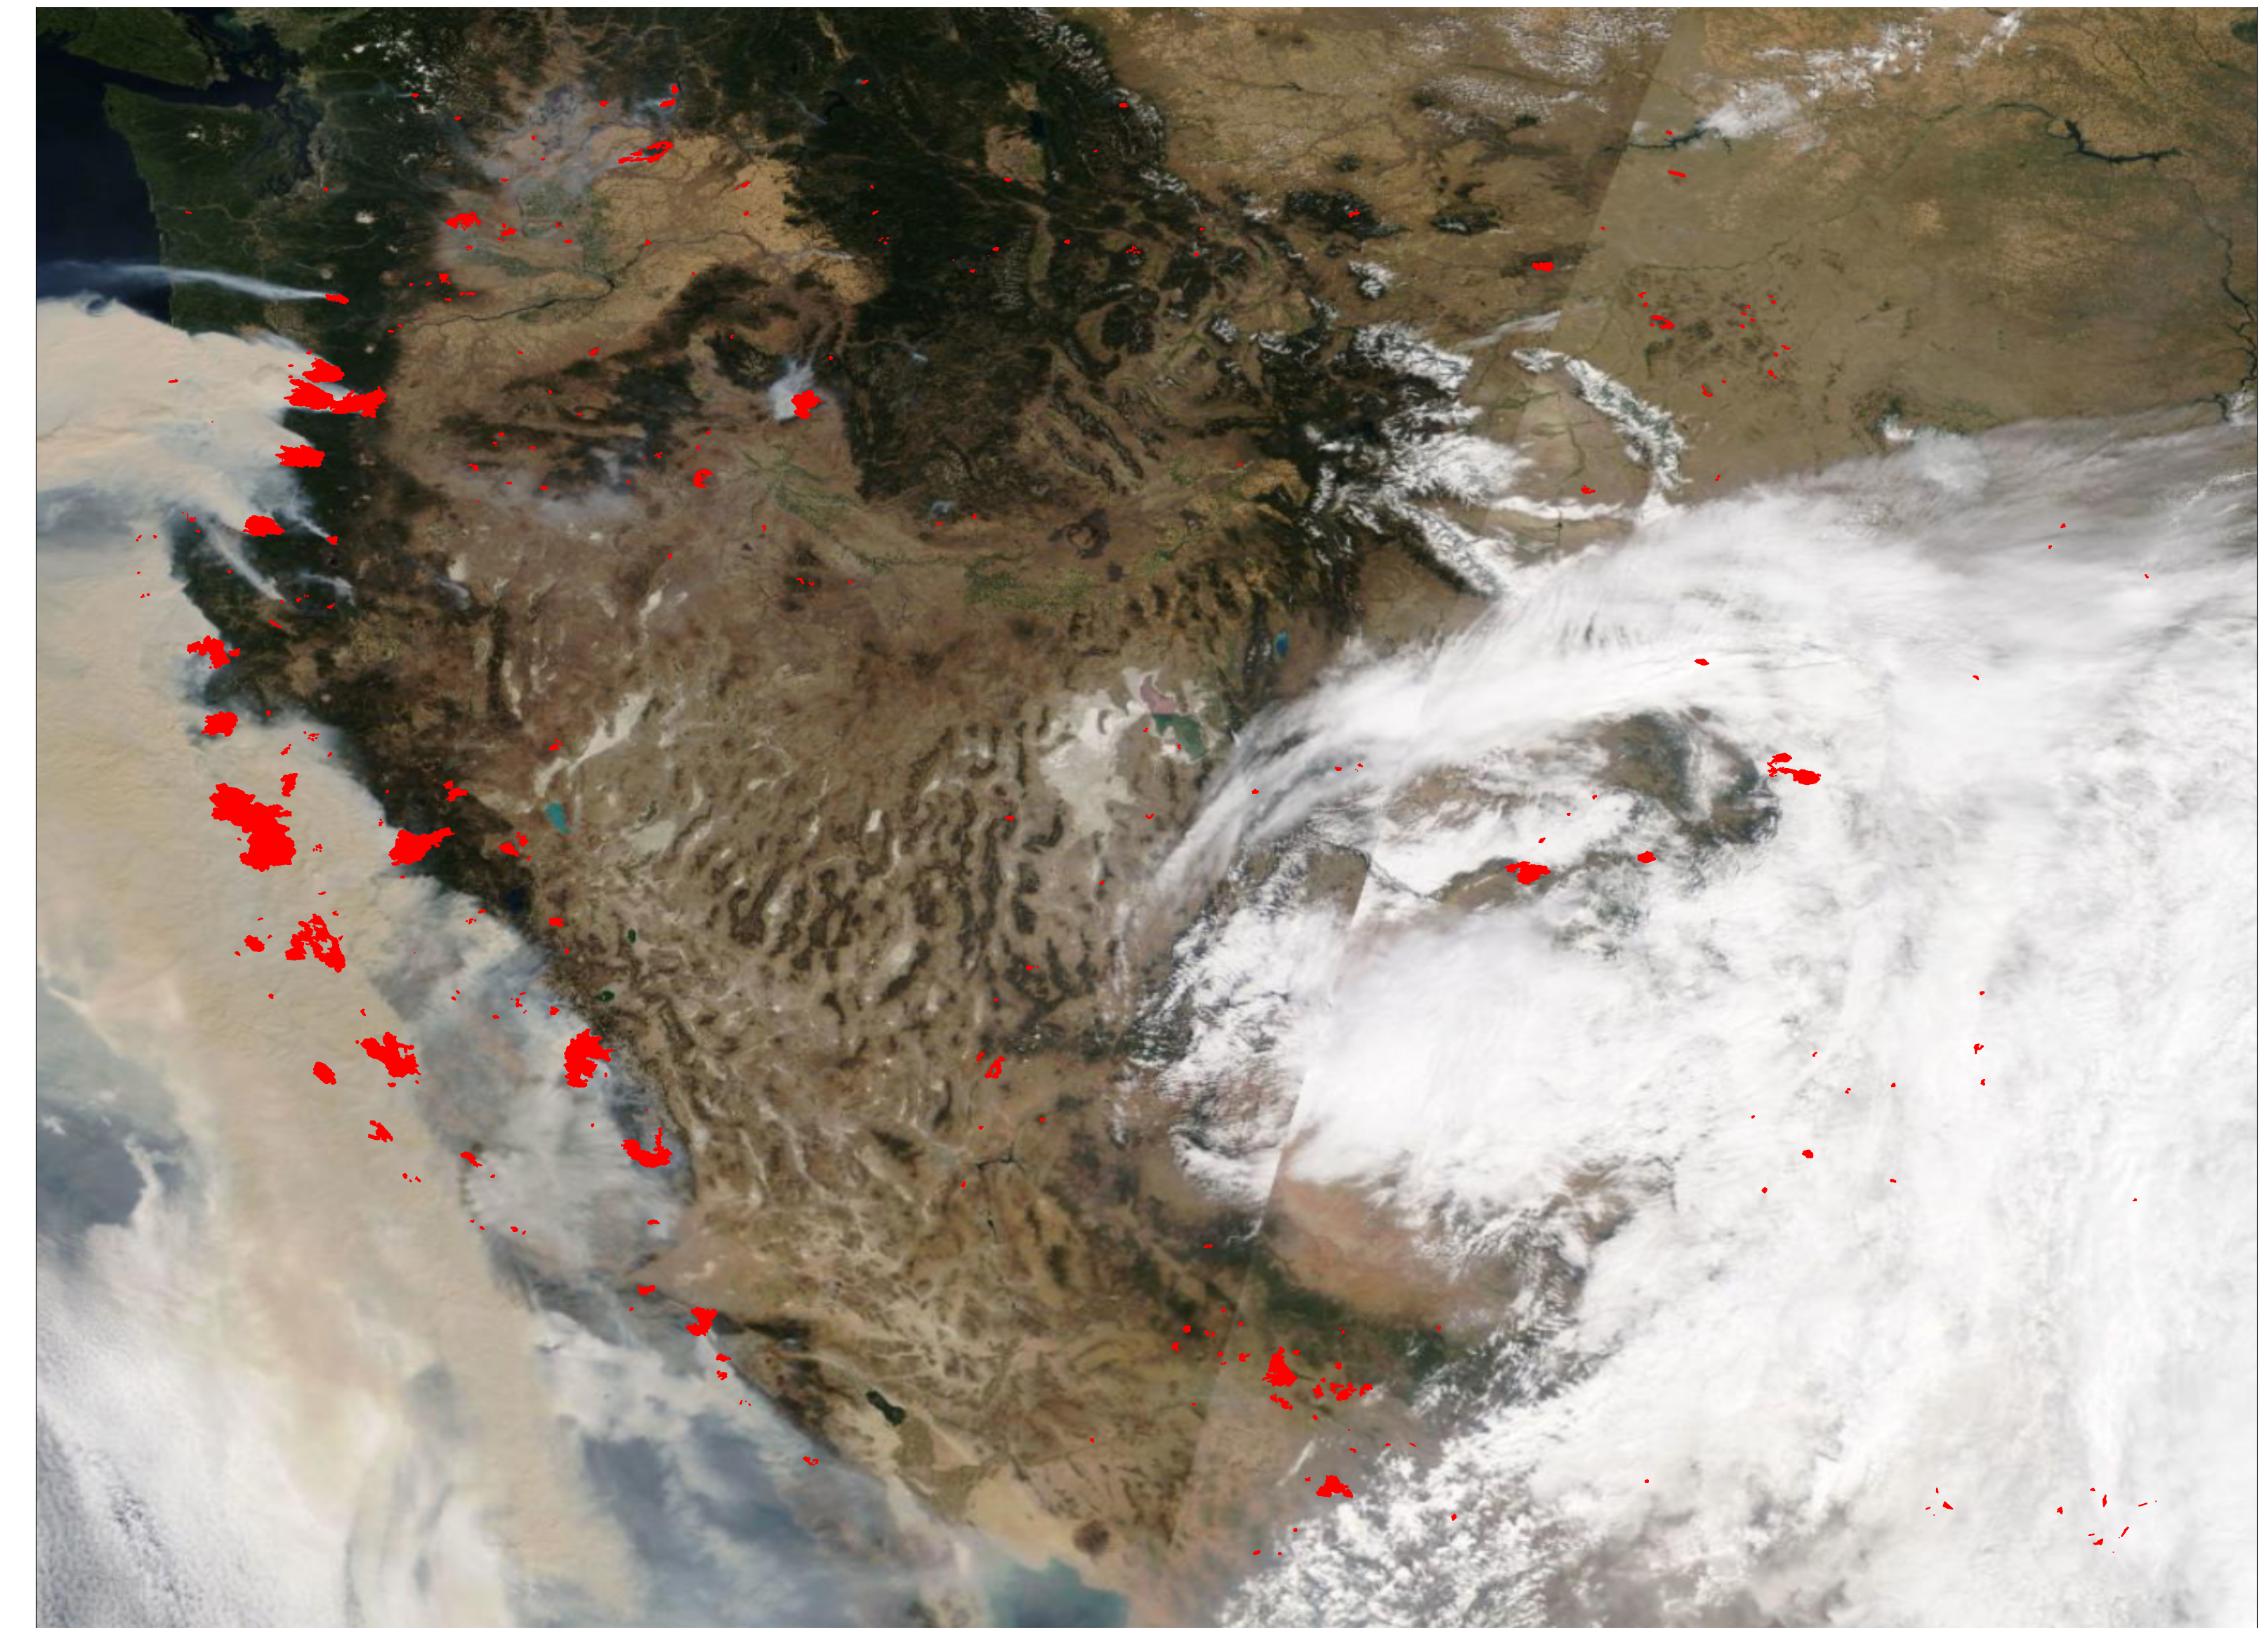

In [31]:
import contextily as cx

ax = tmp.plot(figsize=(53.33333,30), facecolor="red", edgecolor="red")
cx.add_basemap(ax,
                crs="epsg:4326", 
                source= "https://map1.vis.earthdata.nasa.gov/wmts-webmerc/MODIS_Terra_CorrectedReflectance_TrueColor/default/2020-09-09/GoogleMapsCompatible_Level9/{z}/{y}/{x}.jpg")
                #source=cx.providers.NASAGIBS.ModisTerraAOD) #  zoom = 10
#ax.set_title(str(*snap.t.astype('str').unique()), color = "white")
ax.set_title("")
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.xaxis.label.set_color('white')
ax.tick_params(colors='white')
plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')
#ax.set_xlim(-126.4, -61.36) #[-126.401171875,24.071240929282325,-61.36210937500001,49.40003415463647])
#ax.set_ylim(24.07, 49.40)


In [26]:
#plt.plot(tmp)

In [27]:
st_dist = float(manyfr.groupby(  ["fireID"], as_index = False ).st_dist_to_fire.max())
tmp = tmp.merge(st_dist, how = "outer", on = ["fireID"])

/tmp/ipykernel_10538/2207981930.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  st_dist = float(manyfr.groupby(  ["fireID"], as_index = False ).st_dist_to_fire.max())


TypeError: float() argument must be a string or a number, not 'DataFrame'

In [ ]:
tmp["is_diff_negative"] = tmp.diff_fwi <= 0


tmp.explore(column = "is_diff_negative")

In [ ]:
manyfr.columns

In [ ]:
plt.scatter(tmp.diff_fwi, tmp.farea)

In [ ]:
#manyfr[["fireID", "t", "spread_line", 'spread_periodNight', 'spread_periodDay', "spread_aggrigate"]]

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).ISI.max().hist(by = ["spread_aggrigate"],legend = True, bins= 30)




In [ ]:
var = "DC"

fwi_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate_no_igs"], as_index = False)[var].mean()
ig_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate_only_igs"], as_index = False)[var].mean()

bins = np.linspace(0, 50, 100)

plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')
plt.hist(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var], bins, alpha=0.7, label='Stay Day', color = "blue")
plt.hist(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var], bins, alpha=0.7, label='Spread Day', color = "orange")
plt.hist(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var], bins, alpha=0.7, label='Ignitions', color = "green")

#plt.legend(loc='upper right')
#plt.tick_params(size = 18)
plt.show()

print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var].mean())
#print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == False][var].std())
print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var].mean())
#print(fwi_mean[fwi_mean.spread_aggrigate_no_igs == True][var].std())
print(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var].mean())
#print(ig_mean[ig_mean.spread_aggrigate_only_igs == True][var].std())



In [ ]:

ig_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate_only_igs"], as_index = False).FWI.mean()

bins = np.linspace(0, 150, 100)

plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')
plt.hist(ig_mean[ig_mean.spread_aggrigate_only_igs == False].FWI, bins, alpha=0.7, label='Stay Day', color = "blue")
plt.hist(ig_mean[ig_mean.spread_aggrigate_only_igs == True].FWI, bins, alpha=0.7, label='Spread Day', color = "orange")
plt.legend(loc='upper right')
#plt.tick_params(size = 18)
plt.show()

print(fwi_mean[fwi_mean.spread_aggrigate_only_igs == False].FWI.mean())
print(fwi_mean[fwi_mean.spread_aggrigate_only_igs == False].FWI.std())
print(fwi_mean[fwi_mean.spread_aggrigate_only_igs == True].FWI.mean())

In [ ]:
fwi_mean = manyfr.groupby(by = ["fireID", "spread_aggrigate"], as_index = False).FWI.mean()

#plt.hist(fwi_mean, by = "spread_aggrigate")
fwi_mean.columns

In [ ]:
len(fwi_mean.fireID.unique())

In [ ]:
bins = np.linspace(0, 150, 100)

plt.rcParams.update({'font.size': 18})
plt.style.use('dark_background')
plt.hist(fwi_mean[fwi_mean.spread_aggrigate == False].FWI, bins, alpha=0.7, label='Stay Day', color = "blue")
plt.hist(fwi_mean[fwi_mean.spread_aggrigate == True].FWI, bins, alpha=0.7, label='Spread Day', color = "orange")
plt.legend(loc='upper right')
#plt.tick_params(size = 18)
plt.show()

print(fwi_mean[fwi_mean.spread_aggrigate == False].FWI.mean())
print(fwi_mean[fwi_mean.spread_aggrigate == False].FWI.std())
print(fwi_mean[fwi_mean.spread_aggrigate == True].FWI.mean())
print(fwi_mean[fwi_mean.spread_aggrigate == True].FWI.std())

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).FWI.quantile().dropna().hist(by = ["spread_aggrigate"],legend = True, bins= 30)

In [ ]:
grouped = manyfr.groupby(by = ["fireID", "spread_aggrigate"])[["FWI", "ISI"]]

In [ ]:
manyfr.groupby(by = ["fireID", "spread_aggrigate"])[["FWI", "ISI"]].mean().dropna()

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).FWI.min().hist(by = ["spread_aggrigate"],
                                                                           legend = True,
                                                                           bins= 30, 
                                                                           stacked = True ,
                                                                           density = True)
#test.x

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).ISI.max()

In [ ]:
test.index.names

In [ ]:
test['spread_aggrigate']

In [2]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import sys
sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [ ]:
neon = gpd.read_file("/projects/old_shared/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")


In [ ]:
### Get all IDs

flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/")


import re

file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
file_ids = [re.sub("F", "", x) for x in file_ids]

file_ids = set(file_ids)

In [ ]:
len(file_ids)

In [3]:
manyfr = pd.read_csv("/projects/old_shared/fire_spread/WesternUS_REDO_all_west_2020_2023-08-01station_spread.csv")

/tmp/ipykernel_447/2579067106.py:1: DtypeWarning: Columns (10,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  manyfr = pd.read_csv("/projects/old_shared/fire_spread/WesternUS_REDO_all_west_2020_2023-08-01station_spread.csv")


In [4]:
len(manyfr.fireID.unique())

301

In [9]:
manyfr.columns

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'fline_diff', 'farea_diff', 'spread_line', 'spread_lineNight',
       'spread_lineDay', 'spread_day', 'st_ID', 'st_dist_to_fire', 'YYYY',
       'MM', 'DD', 'HH', 'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'PREC_MM', 'SNOWD_M', 'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI',
       'OBSMINUTEDIFFTEMP', 'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD',
       'OBSMINUTEDIFFPREC', 'OBSMINUTEDIFFSNOW', 'HH_format',
       'spread_periodNight', 'spread_periodNight_igs',
       'spread_periodNight_lag_-2', 'spread_periodNight_lag_-4',
       'spread_periodNight_lag_-12', 'spread_periodNight_lag_-24',
       'spread_periodNight_lag_-48', 'spread_periodDay',
       'spread_periodDay_igs', 'spread_periodDay_lag_-2',
       'spread_periodDay_lag_-4', 'spread_periodDay_lag_-12',
       'spread_periodDay_lag_-24', 'spread_periodDay_lag_-

In [10]:
manyfr["spread_aggrigate"] = (manyfr['spread_periodNight'] | manyfr['spread_periodDay'] | manyfr['spread_periodNight_igs'] | manyfr['spread_periodDay_igs'])
                                           
    

In [11]:
manyfr.groupby(by = ["fireID", "spread_periodNight"]).FWI.mean()

fireID  spread_periodNight
67      False                  1.925722
        True                   2.387790
173     False                       NaN
        True                        NaN
186     False                  2.320152
                                ...    
20084   False                  2.061544
        True                   1.815324
20216   False                       NaN
20293   False                 33.853000
        True                  31.583615
Name: FWI, Length: 522, dtype: float64

In [12]:
manyfr["spread_aggrigate"].unique()

array([ True, False])

In [ ]:
#manyfr[["fireID", "t", "spread_line", 'spread_periodNight', 'spread_periodDay', "spread_aggrigate"]]

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).ISI.max().hist(by = ["spread_aggrigate"],legend = True, bins= 30)

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).FWI.quantile().dropna().hist(by = ["spread_aggrigate"],legend = True, bins= 30)

In [ ]:
grouped = manyfr.groupby(by = ["fireID", "spread_aggrigate"])[["FWI", "ISI"]]

In [ ]:
manyfr.groupby(by = ["fireID", "spread_aggrigate"])[["FWI", "ISI"]].mean().dropna()

In [ ]:
test = manyfr.groupby(by = ["fireID", "spread_aggrigate"]).ISI.max()

In [ ]:
test.index.names

In [ ]:
test['spread_aggrigate']

In [ ]:
?plt.hist